<a href="https://colab.research.google.com/github/Nitroblaster99/american_sign_language_CNN/blob/main/American_Sign_Language_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Upload Data

In [1]:
! pip install -q kaggle

In [ ]:
from google.colab import files

files.upload()

In [3]:
! mkdir ~/.kaggle

! cp kaggle.json ~/.kaggle/

In [4]:
! chmod 600 /root/.kaggle/kaggle.json

In [ ]:
! kaggle datasets download datamunge/sign-language-mnist

In [6]:
! unzip sign-language-mnist

Archive:  sign-language-mnist.zip
  inflating: amer_sign2.png          
  inflating: amer_sign3.png          
  inflating: american_sign_language.PNG  
  inflating: sign_mnist_test.csv     
  inflating: sign_mnist_test/sign_mnist_test.csv  
  inflating: sign_mnist_train.csv    
  inflating: sign_mnist_train/sign_mnist_train.csv  


Import libraries

In [7]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import keras
from keras.models import Sequential
from keras.layers import Dense, Conv2D , MaxPool2D , Flatten , Dropout , BatchNormalization
from keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from keras.callbacks import ReduceLROnPlateau

Data preparation

In [211]:
train_df = 'sign_mnist_train.csv'
test_df = 'sign_mnist_test.csv'

train = pd.read_csv(train_df)
test = pd.read_csv(test_df)

In [234]:
train.head()

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,3,107,118,127,134,139,143,146,150,153,...,207,207,207,207,206,206,206,204,203,202
1,6,155,157,156,156,156,157,156,158,158,...,69,149,128,87,94,163,175,103,135,149
2,2,187,188,188,187,187,186,187,188,187,...,202,201,200,199,198,199,198,195,194,195
3,2,211,211,212,212,211,210,211,210,210,...,235,234,233,231,230,226,225,222,229,163
4,13,164,167,170,172,176,179,180,184,185,...,92,105,105,108,133,163,157,163,164,179


In [209]:
test.head()

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,6,149,149,150,150,150,151,151,150,151,...,138,148,127,89,82,96,106,112,120,107
1,5,126,128,131,132,133,134,135,135,136,...,47,104,194,183,186,184,184,184,182,180
2,10,85,88,92,96,105,123,135,143,147,...,68,166,242,227,230,227,226,225,224,222
3,0,203,205,207,206,207,209,210,209,210,...,154,248,247,248,253,236,230,240,253,255
4,3,188,191,193,195,199,201,202,203,203,...,26,40,64,48,29,46,49,46,46,53


In [221]:
print("Train null values: ", train.isnull().any().sum())
print("Test null values: ", test.isnull().any().sum())

Train null values:  0
Test null values:  0


In [222]:
y_train = train['label']

X_train = train.drop(labels = ['label'], axis=1)

In [223]:
y_test = test['label']

X_test = test.drop(labels=['label'], axis=1)

In [224]:
y_train.value_counts().sort_index()

0     1126
1     1010
2     1144
3     1196
4      957
5     1204
6     1090
7     1013
8     1162
10    1114
11    1241
12    1055
13    1151
14    1196
15    1088
16    1279
17    1294
18    1199
19    1186
20    1161
21    1082
22    1225
23    1164
24    1118
Name: label, dtype: int64

In [225]:
X_test.head()

,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,pixel10,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,149,149,150,150,150,151,151,150,151,152,...,138,148,127,89,82,96,106,112,120,107
1,126,128,131,132,133,134,135,135,136,138,...,47,104,194,183,186,184,184,184,182,180
2,85,88,92,96,105,123,135,143,147,152,...,68,166,242,227,230,227,226,225,224,222
3,203,205,207,206,207,209,210,209,210,209,...,154,248,247,248,253,236,230,240,253,255
4,188,191,193,195,199,201,202,203,203,203,...,26,40,64,48,29,46,49,46,46,53


Visualize Labels

<ipython-input-252-bb88bce03e62>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=train['label'], data=train, palette="flare")


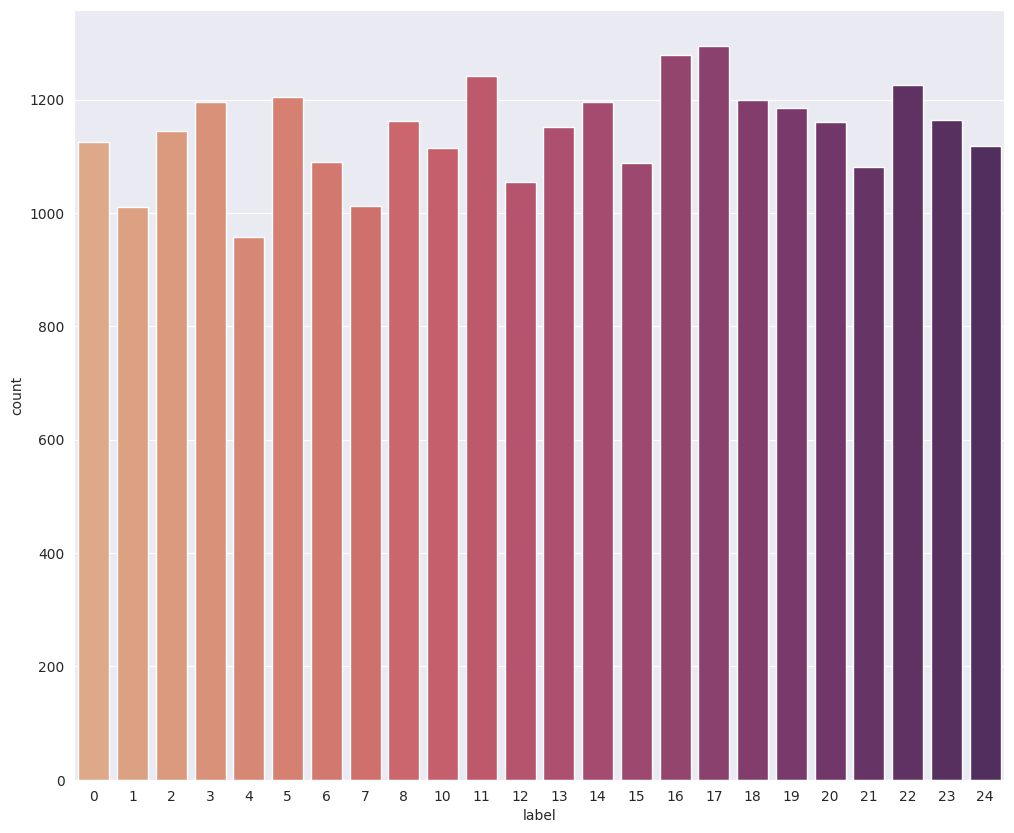

In [252]:
plt.figure(figsize=(12,10))
sns.set_style('darkgrid')
sns.countplot(x=train['label'], data=train, palette="flare")
plt.show()

In [253]:
y_train.shape

(27455,)

In [254]:
y_train

0         3
1         6
2         2
3         2
4        13
         ..
27450    13
27451    23
27452    18
27453    17
27454    23
Name: label, Length: 27455, dtype: int64

Fit Transformer

LabelBinarizer: Binarizes labels in a one-vs-all fashion.

In [255]:
from sklearn.preprocessing import LabelBinarizer
label_binarizer = LabelBinarizer()
y_train = label_binarizer.fit_transform(y_train)
y_test = label_binarizer.fit_transform(y_test)

In [256]:
y_train.shape

(27455, 24)

In [257]:
y_train

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 1, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 1, 0]])

Reshape

In [258]:
X_train = X_train.values.reshape(-1,28,28,1)
X_test = X_test.values.reshape(-1,28,28,1)

Normalization

In [259]:
X_train = X_train/255.0
X_test = X_test/255.0

Visualize

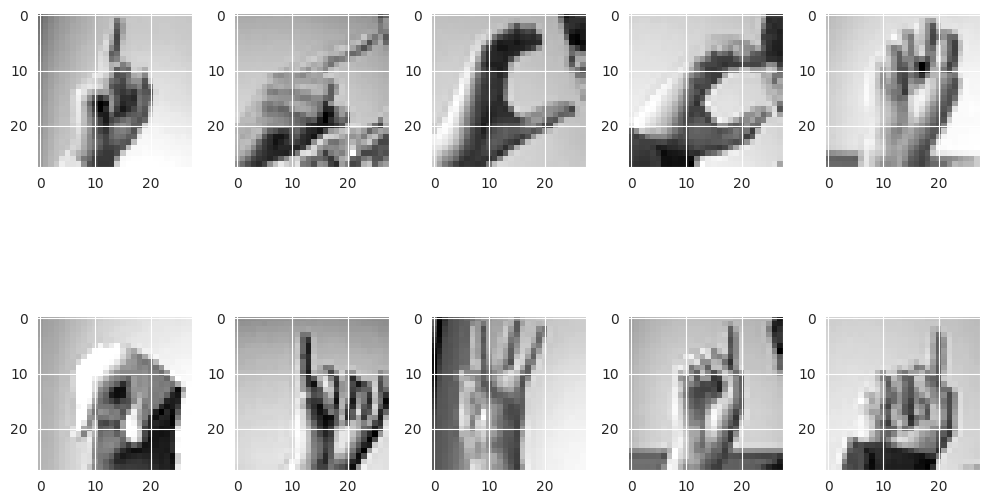

In [260]:
f, ax = plt.subplots(2,5)
f.set_size_inches(10,10)
k = 0
for i in range(2):
  for j in range(5):
    ax[i,j].imshow(X_train[k].reshape(28,28), cmap='gray')
    k += 1
    plt.tight_layout()

Data Augmentation

In [261]:
datagen = ImageDataGenerator(
    rotation_range = 10,
    zoom_range = 0.2,
    width_shift_range=0.1,
    height_shift_range=0.1
)

datagen.fit(X_train)

Visualize after Augmentation

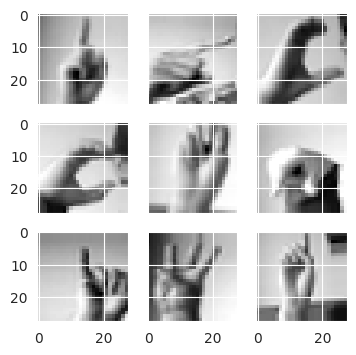

In [262]:
for X_batch, y_batch in datagen.flow(X_train, y_train, batch_size=9, shuffle=False):
    # create a grid of 3x3 images
    fig, ax = plt.subplots(3, 3, sharex=True, sharey=True, figsize=(4,4))
    for i in range(3):
        for j in range(3):
            ax[i][j].imshow(X_batch[i*3+j].reshape(28,28), cmap=plt.get_cmap("gray"))
    # show the plot
    plt.show()
    break

ReduceLROnPlateau:

Reduce learning rate when a metric has stopped improving.

Models often benefit from reducing the learning rate by a factor of 2-10 once learning stagnates. This callback monitors a quantity and if no improvement is seen for a 'patience' number of epochs, the learning rate is reduced.

In [263]:
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', patience=2,
                                            verbose=1, factor=0.5, min_lr=0.00001)

CNN

In [264]:
model = Sequential()

model.add(Conv2D(filters=32, kernel_size=(3,3), strides=1, padding='same',
                 activation='relu', input_shape=(28,28,1)))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2,2), strides=2, padding='same'))
model.add(Conv2D(filters=32, kernel_size=(3,3), strides=1, padding='same',
                 activation='relu'))
model.add(Dropout(0.2))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2,2), strides=2, padding='same'))
model.add(Conv2D(filters=64, kernel_size=(3,3), strides=1, padding='same',
                 activation='relu'))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2,2), padding='same'))
model.add(Flatten())

model.add(Dense(128, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(24, activation='softmax'))


In [265]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [266]:
model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_15 (Conv2D)          (None, 28, 28, 32)        320       
                                                                 
 batch_normalization_15 (Ba  (None, 28, 28, 32)        128       
 tchNormalization)                                               
                                                                 
 max_pooling2d_15 (MaxPooli  (None, 14, 14, 32)        0         
 ng2D)                                                           
                                                                 
 conv2d_16 (Conv2D)          (None, 14, 14, 32)        9248      
                                                                 
 dropout_10 (Dropout)        (None, 14, 14, 32)        0         
                                                                 
 batch_normalization_16 (Ba  (None, 14, 14, 32)       

In [267]:
history = model.fit(datagen.flow(X_train, y_train, batch_size=128),
                    epochs=12, validation_data=(X_test, y_test),
                    callbacks=[learning_rate_reduction])

Epoch 1/12
215/215 [==============================] - 13s 49ms/step - loss: 1.4988 - accuracy: 0.5326 - val_loss: 3.9853 - val_accuracy: 0.0660 - lr: 0.0010
Epoch 2/12
215/215 [==============================] - 10s 48ms/step - loss: 0.4686 - accuracy: 0.8406 - val_loss: 1.6718 - val_accuracy: 0.5096 - lr: 0.0010
Epoch 3/12
215/215 [==============================] - 10s 48ms/step - loss: 0.2443 - accuracy: 0.9180 - val_loss: 0.1468 - val_accuracy: 0.9502 - lr: 0.0010
Epoch 4/12
215/215 [==============================] - 10s 48ms/step - loss: 0.1688 - accuracy: 0.9427 - val_loss: 0.0873 - val_accuracy: 0.9731 - lr: 0.0010
Epoch 5/12
215/215 [==============================] - 10s 48ms/step - loss: 0.1167 - accuracy: 0.9600 - val_loss: 0.0327 - val_accuracy: 0.9893 - lr: 0.0010
Epoch 6/12
215/215 [==============================] - 12s 58ms/step - loss: 0.0938 - accuracy: 0.9674 - val_loss: 0.0098 - val_accuracy: 0.9969 - lr: 0.0010
Epoch 7/12
215/215 [==============================] - 10s 

Evaluation

In [268]:
print('Accuracy of the model is: ', model.evaluate(X_test, y_test)[1]*100, '%')

225/225 [==============================] - 1s 3ms/step - loss: 0.0075 - accuracy: 0.9982
Accuracy of the model is:  99.81874227523804 %


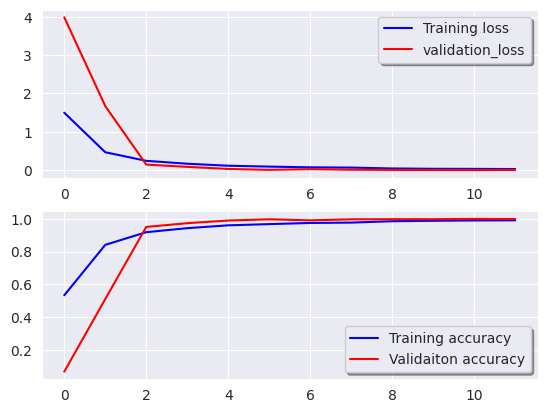

In [269]:
# Plot the loss and accuracy curves for training and validation

fig, ax = plt.subplots(2,1)
ax[0].plot(history.history['loss'], color='b', label='Training loss')
ax[0].plot(history.history['val_loss'], color='r', label='validation_loss')
legend=ax[0].legend(loc='best', shadow=True)

ax[1].plot(history.history['accuracy'], color='b', label='Training accuracy')
ax[1].plot(history.history['val_accuracy'], color='r', label='Validaiton accuracy')
legend = ax[1].legend(loc='best', shadow=True)

In [270]:
rounded_labels=np.argmax(y_test, axis=1)
y_pred = model.predict(X_test)
predictions = np.argmax(y_pred, axis=1)

225/225 [==============================] - 1s 2ms/step


Classification Report

In [271]:
print(classification_report(rounded_labels, predictions))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       331
           1       1.00      1.00      1.00       432
           2       1.00      1.00      1.00       310
           3       1.00      1.00      1.00       245
           4       1.00      1.00      1.00       498
           5       1.00      1.00      1.00       247
           6       1.00      0.99      1.00       348
           7       1.00      1.00      1.00       436
           8       1.00      1.00      1.00       288
           9       1.00      1.00      1.00       331
          10       1.00      0.99      1.00       209
          11       1.00      0.99      1.00       394
          12       0.99      1.00      0.99       291
          13       1.00      1.00      1.00       246
          14       1.00      1.00      1.00       347
          15       1.00      1.00      1.00       164
          16       0.99      1.00      0.99       144
          17       1.00    

Confusion Matrix

In [272]:
import itertools

def plot_confusion_matrix(cm, classes, normalize=False,
                          title='Confusion Matrix',
                          cmap=plt.cm.Blues):
  plt.figure(figsize = (15,15))

  plt.imshow(cm, interpolation='nearest', cmap=cmap)
  plt.title(title)
  plt.colorbar(shrink=0.8)
  tick_marks = np.arange(len(classes))
  plt.xticks(tick_marks, classes, rotation=45)
  plt.yticks(tick_marks, classes)

  if normalize:
    cm = cm.astype('flaot') / cm.sum(axis=1)[:,np.newaxis]

  thresh = cm.max()/2.
  for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(i,j, cm[i,j],
              horizontalalignment='center',
              color='white' if cm[i,j]>thresh else 'black')


  plt.ylabel('True label')
  plt.xlabel('Predicted label')

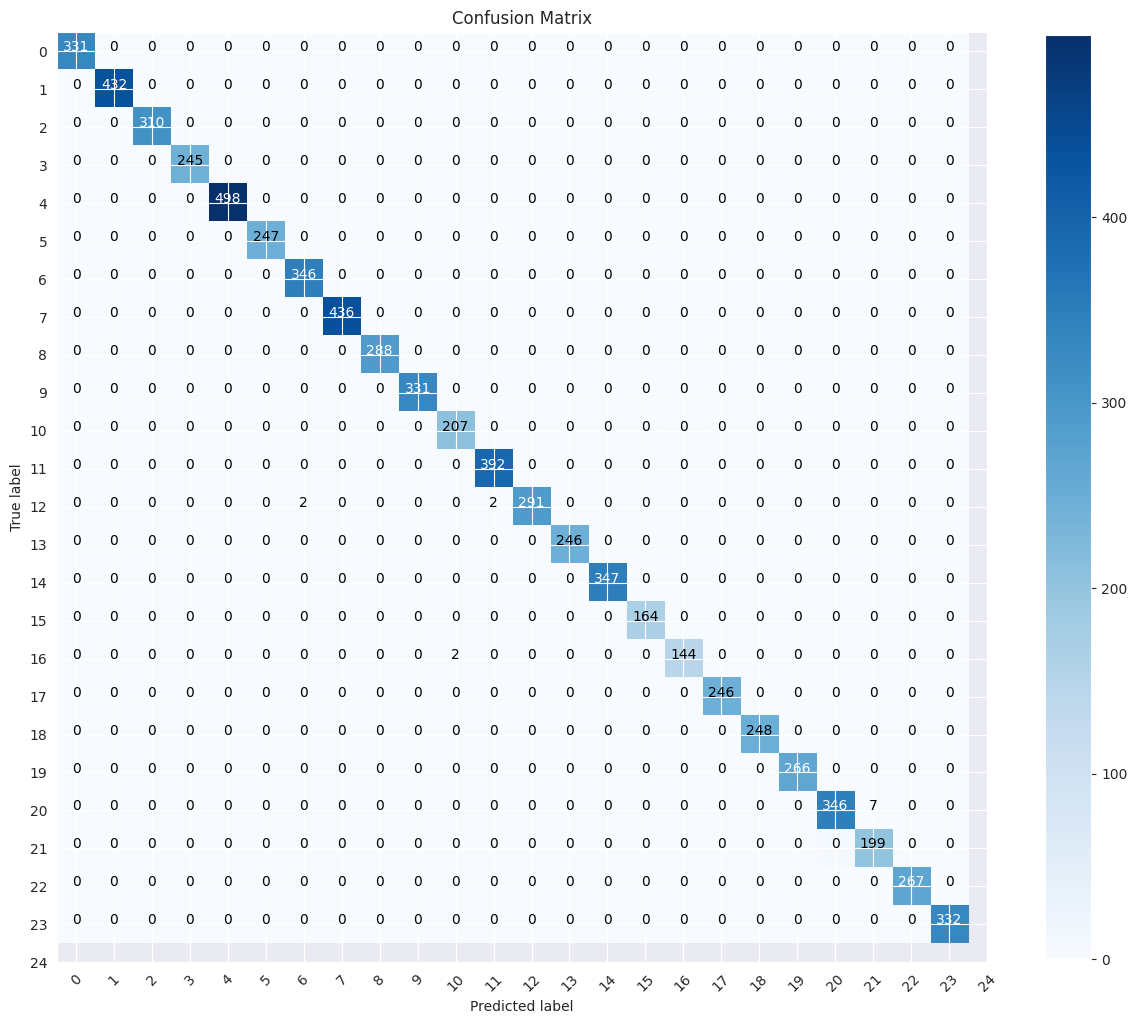

In [273]:
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_test, axis=1)

confusion_mtx = confusion_matrix(y_true, y_pred_classes)
plot_confusion_matrix(confusion_mtx, classes=range(25))

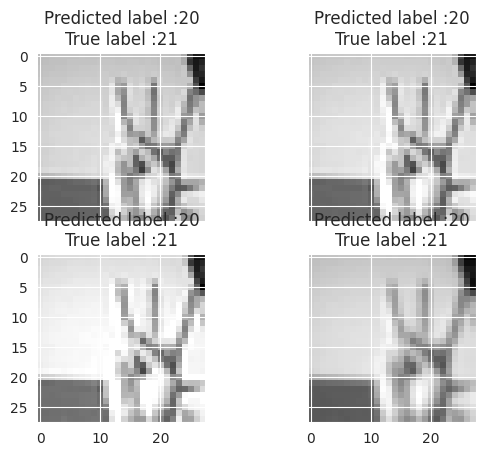

In [274]:
# Display some error results

errors = (y_pred_classes - y_true !=0)

y_pred_classes_errors= y_pred_classes[errors]
y_pred_errors = y_pred[errors]
y_true_errors = y_true[errors]
X_val_errors = X_test[errors]

def display_errors(errors_index,img_errors,pred_errors, obs_errors):
    """ This function shows 4 images with their predicted and real labels"""
    n = 0
    nrows = 2
    ncols = 2
    fig, ax = plt.subplots(nrows,ncols,sharex=True,sharey=True)
    for row in range(nrows):
        for col in range(ncols):
            error = errors_index[n]
            ax[row,col].imshow((img_errors[error]).reshape((28,28)), cmap='gray')
            ax[row,col].set_title("Predicted label :{}\nTrue label :{}".format(pred_errors[error],obs_errors[error]))
            n += 1

# Probabilities of the wrong predicted numbers
y_pred_errors_prob = np.max(y_pred_errors,axis = 1)

# Predicted probabilities of the true values in the error set
true_prob_errors = np.diagonal(np.take(y_pred_errors, y_true_errors, axis=1))

# Difference between the probability of the predicted label and the true label
delta_pred_true_errors = y_pred_errors_prob - true_prob_errors

# Sorted list of the delta prob errors
sorted_dela_errors = np.argsort(delta_pred_true_errors)

# Top 6 errors
most_important_errors = sorted_dela_errors[-4:]

# Show the top 6 errors
display_errors(most_important_errors, X_val_errors, y_pred_classes_errors, y_true_errors)